In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numpy as np
from matplotlib import pyplot as ptl
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
con = sqlite3.connect("../data/chembl_29.db")

In [4]:
molregno_chembl_id = pd.read_sql_query("SELECT compound_properties.*, molecule_dictionary.chembl_id, compound_structures.canonical_smiles FROM compound_properties INNER JOIN compound_structures ON compound_structures.molregno=compound_properties.molregno INNER JOIN molecule_dictionary ON molecule_dictionary.molregno=compound_properties.molregno;", con)

In [5]:
molregno_chembl_id

,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,chembl_id,canonical_smiles
0,1,341.75,2.11,5.0,1.0,84.82,3.0,N,0.0,6.48,NaN,3.63,2.69,ACID,341.75,3.0,24.0,0.74,341.0567,C17H12ClN3O3,6.0,1.0,0.0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl
1,2,332.32,1.33,6.0,1.0,108.61,3.0,N,0.0,6.33,NaN,2.88,1.82,ACID,332.32,3.0,25.0,0.73,332.0909,C18H12N4O3,7.0,1.0,0.0,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1
2,3,357.80,2.27,5.0,2.0,87.98,3.0,N,0.0,6.33,NaN,3.70,2.64,ACID,357.80,3.0,25.0,0.75,357.0880,C18H16ClN3O3,6.0,2.0,0.0,CHEMBL265667,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1
3,4,307.31,1.46,5.0,1.0,84.82,3.0,N,0.0,6.33,NaN,3.02,1.97,ACID,307.31,3.0,23.0,0.74,307.0957,C17H13N3O3,6.0,1.0,0.0,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1
4,5,341.75,2.11,5.0,1.0,84.82,3.0,N,0.0,6.33,NaN,3.63,2.57,ACID,341.75,3.0,24.0,0.74,341.0567,C17H12ClN3O3,6.0,1.0,0.0,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2084719,2487510,556.38,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,556.38,NaN,NaN,NaN,556.2055,C31H32BNO6P+,NaN,NaN,NaN,CHEMBL4651250,COc1ccc([P+](CCC(=O)Nc2ccc3c(c2)B(O)OC3)(c2ccc...
2084720,2487511,378.30,3.13,3.0,2.0,58.36,5.0,N,0.0,NaN,9.33,2.96,0.43,BASE,378.30,2.0,25.0,0.84,377.1062,C19H21Cl2N3O,4.0,3.0,0.0,CHEMBL4651251,CNCc1ccc2c(c1)CN(C(=O)[C@H](N)Cc1ccc(Cl)cc1Cl)C2
2084721,2487512,356.42,2.29,5.0,4.0,90.82,7.0,N,0.0,9.18,9.79,1.64,0.31,BASE,356.42,2.0,26.0,0.57,356.1736,C20H24N2O4,6.0,4.0,0.0,CHEMBL4651252,Cc1ccc(CCCNCC(O)c2cc(O)cc3c2OCC(=O)N3)cc1
2084722,2487513,1023.94,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,1023.94,NaN,NaN,NaN,1023.2919,C42H61FN3O17P3S,NaN,NaN,NaN,CHEMBL4651253,CCCCCCCCCCCCCCCCOC(=O)Oc1ccc(COP(=O)(OCc2ccc(O...


In [6]:
cruzain_id = pd.read_csv('data/cruzain_id_chemb.csv')

In [7]:
cruzain_id

,Molecule ChEMBL ID
0,CHEMBL568312
1,CHEMBL3347276
2,CHEMBL3347366
3,CHEMBL3347331
4,CHEMBL3347321
...,...
710,CHEMBL4434707
711,CHEMBL3329515
712,CHEMBL4283566
713,CHEMBL4465398


In [8]:
cruzain_id = cruzain_id["Molecule ChEMBL ID"]
cruzain_id

0       CHEMBL568312
1      CHEMBL3347276
2      CHEMBL3347366
3      CHEMBL3347331
4      CHEMBL3347321
           ...      
710    CHEMBL4434707
711    CHEMBL3329515
712    CHEMBL4283566
713    CHEMBL4465398
714    CHEMBL4067684
Name: Molecule ChEMBL ID, Length: 715, dtype: object

In [9]:
molregno_chembl_id = molregno_chembl_id.query("chembl_id in @cruzain_id")

In [10]:
molregno_chembl_id.head()

,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,chembl_id,canonical_smiles
1046,1219,454.61,5.09,6.0,0.0,63.95,13.0,N,1.0,NaN,9.68,5.04,2.79,BASE,454.61,2.0,33.0,0.42,454.2832,C27H38N2O4,6.0,0.0,1.0,CHEMBL6966,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...
12779,14790,303.84,4.18,3.0,1.0,28.16,5.0,N,0.0,NaN,9.55,3.14,0.81,BASE,303.84,2.0,21.0,0.84,303.1502,C17H22ClN3,3.0,1.0,0.0,CHEMBL14498,Clc1ccc2c(NCCCN3CCCCC3)ccnc2c1
13755,15890,260.25,1.11,5.0,1.0,90.06,5.0,N,0.0,13.68,0.20,1.32,1.32,NEUTRAL,260.25,2.0,19.0,0.64,260.0909,C12H12N4O3,7.0,1.0,0.0,CHEMBL110,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1
14740,17169,670.86,3.09,7.0,5.0,166.75,12.0,N,1.0,13.61,8.47,3.16,2.05,NEUTRAL,670.86,3.0,49.0,0.20,670.3843,C38H50N6O5,11.0,6.0,3.0,CHEMBL114,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...
15918,18589,274.36,4.91,1.0,0.0,17.07,2.0,N,0.0,NaN,NaN,5.60,5.60,NEUTRAL,274.36,2.0,21.0,0.71,274.1358,C20H18O,1.0,0.0,0.0,CHEMBL274993,O=C1/C(=C/c2ccccc2)CCC/C1=C\c1ccccc1


In [11]:
pd.set_option('display.max_columns', None)

In [12]:
molregno_chembl_id.num_lipinski_ro5_violations.unique()

array([ 1.,  0.,  3.,  2., nan])

In [13]:
molregno_chembl_id.num_ro5_violations.unique()

array([ 1.,  0.,  2., nan])

In [14]:
molregno_chembl_id[molregno_chembl_id.num_lipinski_ro5_violations == molregno_chembl_id.num_ro5_violations]

,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,chembl_id,canonical_smiles
1046,1219,454.61,5.09,6.0,0.0,63.95,13.0,N,1.0,NaN,9.68,5.04,2.79,BASE,454.61,2.0,33.0,0.42,454.2832,C27H38N2O4,6.0,0.0,1.0,CHEMBL6966,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...
12779,14790,303.84,4.18,3.0,1.0,28.16,5.0,N,0.0,NaN,9.55,3.14,0.81,BASE,303.84,2.0,21.0,0.84,303.1502,C17H22ClN3,3.0,1.0,0.0,CHEMBL14498,Clc1ccc2c(NCCCN3CCCCC3)ccnc2c1
13755,15890,260.25,1.11,5.0,1.0,90.06,5.0,N,0.0,13.68,0.20,1.32,1.32,NEUTRAL,260.25,2.0,19.0,0.64,260.0909,C12H12N4O3,7.0,1.0,0.0,CHEMBL110,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1
15918,18589,274.36,4.91,1.0,0.0,17.07,2.0,N,0.0,NaN,NaN,5.60,5.60,NEUTRAL,274.36,2.0,21.0,0.71,274.1358,C20H18O,1.0,0.0,0.0,CHEMBL274993,O=C1/C(=C/c2ccccc2)CCC/C1=C\c1ccccc1
23818,27688,162.15,1.04,4.0,2.0,66.24,0.0,N,0.0,11.21,NaN,1.88,1.88,NEUTRAL,162.15,2.0,12.0,0.61,162.0429,C8H6N2O2,4.0,2.0,0.0,CHEMBL282672,Oc1nc2ccccc2nc1O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033195,2434443,370.46,4.91,7.0,1.0,80.42,7.0,N,0.0,11.55,4.90,5.04,5.02,NEUTRAL,370.46,3.0,25.0,0.28,370.0558,C17H14N4O2S2,6.0,1.0,0.0,CHEMBL4564015,O=[N+]([O-])c1ccc(-c2csc(N/N=C/CSc3ccccc3)n2)cc1
2034227,2435496,343.45,5.14,5.0,1.0,37.28,6.0,N,1.0,11.57,4.97,5.24,5.22,NEUTRAL,343.45,3.0,23.0,0.38,343.0613,C17H14FN3S2,3.0,1.0,1.0,CHEMBL4565068,Fc1ccc(-c2csc(N/N=C/CSc3ccccc3)n2)cc1
2034653,2435956,404.36,5.76,5.0,1.0,37.28,6.0,N,1.0,11.57,4.93,5.87,5.85,NEUTRAL,404.36,3.0,23.0,0.32,402.9813,C17H14BrN3S2,3.0,1.0,1.0,CHEMBL4565528,Brc1ccc(-c2csc(N/N=C/CSc3ccccc3)n2)cc1
2037670,2439131,325.46,5.00,5.0,1.0,37.28,6.0,N,1.0,11.60,5.43,5.10,5.04,NEUTRAL,325.46,3.0,22.0,0.39,325.0707,C17H15N3S2,3.0,1.0,1.0,CHEMBL4568703,C(\CSc1ccccc1)=N/Nc1nc(-c2ccccc2)cs1


In [15]:
molregno_chembl_id['ro3_pass'] = molregno_chembl_id['ro3_pass'].replace({"Y": 'True', "N": 'False'})

/tmp/ipykernel_6141/1913271359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molregno_chembl_id['ro3_pass'] = molregno_chembl_id['ro3_pass'].replace({"Y": 'True', "N": 'False'})


In [16]:
molregno_chembl_id.query("num_lipinski_ro5_violations == 0")

,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,chembl_id,canonical_smiles
12779,14790,303.84,4.18,3.0,1.0,28.16,5.0,False,0.0,NaN,9.55,3.14,0.81,BASE,303.84,2.0,21.0,0.84,303.1502,C17H22ClN3,3.0,1.0,0.0,CHEMBL14498,Clc1ccc2c(NCCCN3CCCCC3)ccnc2c1
13755,15890,260.25,1.11,5.0,1.0,90.06,5.0,False,0.0,13.68,0.20,1.32,1.32,NEUTRAL,260.25,2.0,19.0,0.64,260.0909,C12H12N4O3,7.0,1.0,0.0,CHEMBL110,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1
15918,18589,274.36,4.91,1.0,0.0,17.07,2.0,False,0.0,NaN,NaN,5.60,5.60,NEUTRAL,274.36,2.0,21.0,0.71,274.1358,C20H18O,1.0,0.0,0.0,CHEMBL274993,O=C1/C(=C/c2ccccc2)CCC/C1=C\c1ccccc1
23818,27688,162.15,1.04,4.0,2.0,66.24,0.0,False,0.0,11.21,NaN,1.88,1.88,NEUTRAL,162.15,2.0,12.0,0.61,162.0429,C8H6N2O2,4.0,2.0,0.0,CHEMBL282672,Oc1nc2ccccc2nc1O
26568,30864,180.24,0.66,3.0,2.0,63.63,2.0,False,0.0,6.67,3.64,1.23,0.57,NEUTRAL,180.24,1.0,12.0,0.30,180.0470,C7H8N4S,4.0,2.0,0.0,CHEMBL25988,N/C(S)=N/N=C/c1ccccn1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917956,2314469,453.54,2.62,6.0,2.0,101.93,12.0,False,0.0,12.42,NaN,3.98,3.98,NEUTRAL,453.54,2.0,33.0,0.38,453.2151,C26H31NO6,7.0,2.0,0.0,CHEMBL4249898,CCOC(=O)/C=C/[C@H](O)[C@H](CCc1ccccc1)C(=O)N[C...
1961486,2361695,370.46,4.91,7.0,1.0,80.42,7.0,False,0.0,11.56,4.90,5.04,5.02,NEUTRAL,370.46,3.0,25.0,0.28,370.0558,C17H14N4O2S2,6.0,1.0,0.0,CHEMBL4454686,O=[N+]([O-])c1cccc(-c2csc(N/N=C/CSc3ccccc3)n2)c1
2027956,2429054,218.21,0.94,3.0,2.0,83.05,3.0,False,0.0,3.82,1.46,1.05,-2.20,ACID,218.21,2.0,16.0,0.80,218.0691,C11H10N2O3,5.0,2.0,0.0,CHEMBL4558626,O=C(O)CCc1nc2ccccc2[nH]c1=O
2033195,2434443,370.46,4.91,7.0,1.0,80.42,7.0,False,0.0,11.55,4.90,5.04,5.02,NEUTRAL,370.46,3.0,25.0,0.28,370.0558,C17H14N4O2S2,6.0,1.0,0.0,CHEMBL4564015,O=[N+]([O-])c1ccc(-c2csc(N/N=C/CSc3ccccc3)n2)cc1


In [17]:
molregno_chembl_id.query("num_lipinski_ro5_violations == 0 & ro3_pass == 'True'")

,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,chembl_id,canonical_smiles
37668,43896,222.68,2.29,3.0,2.0,45.15,3.0,True,0.0,NaN,7.29,1.52,1.28,NEUTRAL,222.68,2.0,15.0,0.84,222.0560,C11H11ClN2O,3.0,2.0,0.0,CHEMBL31000,OCCNc1ccnc2cc(Cl)ccc12
98388,114631,193.28,1.66,2.0,2.0,50.74,2.0,True,0.0,6.94,3.64,1.61,1.11,NEUTRAL,193.28,1.0,13.0,0.32,193.0674,C9H11N3S,3.0,2.0,0.0,CHEMBL74689,C/C(=N\N=C(/N)S)c1ccccc1
126667,147149,286.20,2.81,2.0,2.0,50.74,3.0,True,0.0,6.60,3.63,3.08,2.39,NEUTRAL,286.20,1.0,15.0,0.38,284.9935,C10H12BrN3S,3.0,2.0,0.0,CHEMBL313679,CC/C(=N\N=C(\N)S)c1cccc(Br)c1
127467,147999,262.17,2.96,2.0,2.0,50.74,2.0,True,0.0,6.31,3.63,2.82,1.98,ACID,262.17,1.0,15.0,0.37,260.9894,C9H9Cl2N3S,3.0,2.0,0.0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1
139048,161080,221.69,2.26,3.0,2.0,50.94,3.0,True,0.0,NaN,9.62,1.41,-0.98,BASE,221.69,2.0,15.0,0.84,221.0720,C11H12ClN3,3.0,3.0,0.0,CHEMBL99254,NCCNc1ccnc2cc(Cl)ccc12
334205,381566,238.25,2.63,3.0,0.0,52.97,2.0,True,0.0,NaN,NaN,2.96,2.96,NEUTRAL,238.25,3.0,18.0,0.51,238.0742,C14H10N2O2,4.0,0.0,0.0,CHEMBL227002,[O-][n+]1onc2cc(/C=C/c3ccccc3)ccc21
334210,381572,238.25,2.63,3.0,0.0,52.97,2.0,True,0.0,NaN,NaN,2.96,2.96,NEUTRAL,238.25,3.0,18.0,0.51,238.0742,C14H10N2O2,4.0,0.0,0.0,CHEMBL226536,[O-][n+]1onc2cc(/C=C\c3ccccc3)ccc21
343404,391517,221.33,1.98,2.0,2.0,50.41,3.0,True,0.0,11.71,3.05,2.91,2.91,NEUTRAL,221.33,1.0,15.0,0.47,221.0987,C11H15N3S,3.0,3.0,0.0,CHEMBL242106,CC(C)c1ccc(/C=N/NC(N)=S)cc1
404555,455835,235.31,1.18,3.0,2.0,59.64,2.0,True,0.0,11.67,2.04,1.66,1.66,NEUTRAL,235.31,1.0,16.0,0.60,235.0779,C11H13N3OS,4.0,3.0,0.0,CHEMBL474331,COc1cccc2c1CC/C2=N\NC(N)=S
404557,455837,235.31,1.18,3.0,2.0,59.64,2.0,True,0.0,11.67,2.01,1.66,1.66,NEUTRAL,235.31,1.0,16.0,0.60,235.0779,C11H13N3OS,4.0,3.0,0.0,CHEMBL474332,COc1ccc2c(c1)/C(=N/NC(N)=S)CC2


In [18]:
prep_clust = pd.get_dummies(molregno_chembl_id.query("num_lipinski_ro5_violations == 0"), columns=["molecular_species"])
tab_usada = prep_clust
prep_clust = prep_clust.drop(['chembl_id','molregno', "num_ro5_violations", "ro3_pass", "full_molformula", "canonical_smiles"], axis=1)


In [19]:
prep_clust.head()

,mw_freebase,alogp,hba,hbd,psa,rtb,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,molecular_species_ACID,molecular_species_BASE,molecular_species_NEUTRAL,molecular_species_ZWITTERION
12779,303.84,4.18,3.0,1.0,28.16,5.0,NaN,9.55,3.14,0.81,303.84,2.0,21.0,0.84,303.1502,3.0,1.0,0.0,0,1,0,0
13755,260.25,1.11,5.0,1.0,90.06,5.0,13.68,0.20,1.32,1.32,260.25,2.0,19.0,0.64,260.0909,7.0,1.0,0.0,0,0,1,0
15918,274.36,4.91,1.0,0.0,17.07,2.0,NaN,NaN,5.60,5.60,274.36,2.0,21.0,0.71,274.1358,1.0,0.0,0.0,0,0,1,0
23818,162.15,1.04,4.0,2.0,66.24,0.0,11.21,NaN,1.88,1.88,162.15,2.0,12.0,0.61,162.0429,4.0,2.0,0.0,0,0,1,0
26568,180.24,0.66,3.0,2.0,63.63,2.0,6.67,3.64,1.23,0.57,180.24,1.0,12.0,0.30,180.0470,4.0,2.0,0.0,0,0,1,0


In [20]:
prep_clust = prep_clust.replace({np.nan: "7"})
prep_clust.head()

,mw_freebase,alogp,hba,hbd,psa,rtb,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,molecular_species_ACID,molecular_species_BASE,molecular_species_NEUTRAL,molecular_species_ZWITTERION
12779,303.84,4.18,3.0,1.0,28.16,5.0,7,9.55,3.14,0.81,303.84,2.0,21.0,0.84,303.1502,3.0,1.0,0.0,0,1,0,0
13755,260.25,1.11,5.0,1.0,90.06,5.0,13.68,0.2,1.32,1.32,260.25,2.0,19.0,0.64,260.0909,7.0,1.0,0.0,0,0,1,0
15918,274.36,4.91,1.0,0.0,17.07,2.0,7,7,5.60,5.60,274.36,2.0,21.0,0.71,274.1358,1.0,0.0,0.0,0,0,1,0
23818,162.15,1.04,4.0,2.0,66.24,0.0,11.21,7,1.88,1.88,162.15,2.0,12.0,0.61,162.0429,4.0,2.0,0.0,0,0,1,0
26568,180.24,0.66,3.0,2.0,63.63,2.0,6.67,3.64,1.23,0.57,180.24,1.0,12.0,0.30,180.0470,4.0,2.0,0.0,0,0,1,0


In [21]:
x = preprocessing.normalize(prep_clust, norm='l1')
cluster = KMeans(n_clusters=3, random_state=5)
cluster.fit(x).labels_

array([2, 0, 2, 0, 0, 1, 0, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       0, 0, 1, 1, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
       2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1,
       1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 0, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

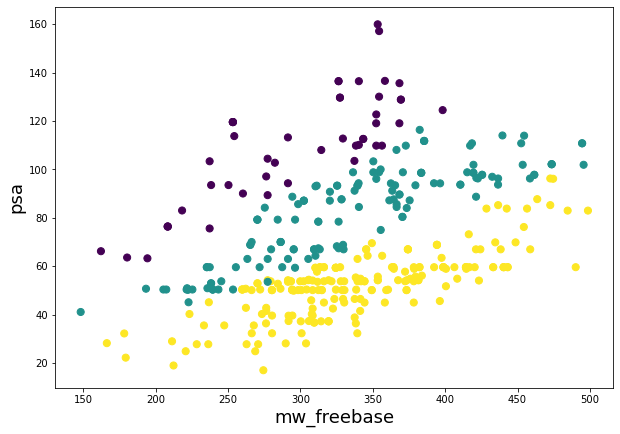

In [22]:
plt.figure(figsize=(10,7))
plt.scatter(x=prep_clust[['mw_freebase']], y=prep_clust.psa, c=cluster.fit(x).labels_, s=50)
plt.xlabel('mw_freebase', fontsize=18)
plt.ylabel('psa', fontsize=18)
plt.show()

In [23]:
tab_usada['grupos_cluster_knn'] = cluster.fit(x).labels_
tab_usada.drop(["num_ro5_violations", "ro3_pass", "num_lipinski_ro5_violations"], axis=1).sort_values(by='grupos_cluster_knn')

,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,chembl_id,canonical_smiles,molecular_species_ACID,molecular_species_BASE,molecular_species_NEUTRAL,molecular_species_ZWITTERION,grupos_cluster_knn
1412701,1731584,340.34,2.21,5.0,2.0,110.15,7.0,11.80,5.36,1.97,1.97,340.34,3.0,25.0,0.51,340.1172,C17H16N4O4,8.0,2.0,CHEMBL3233085,O=C(COc1ccccc1[N+](=O)[O-])NCCc1nc2ccccc2[nH]1,0,0,1,0,0
1468216,1796807,369.38,0.00,5.0,2.0,128.85,5.0,-4.63,1.60,-2.94,-0.47,369.38,2.0,27.0,0.33,369.1437,C18H19N5O4,9.0,3.0,CHEMBL3347377,CC1(C)[N+]([O-])=c2ccc(COc3ccccc3/C=N\NC(N)=O)...,1,0,0,0,0
1226257,1424770,352.31,1.93,8.0,2.0,119.07,4.0,8.81,1.28,3.06,3.04,352.31,3.0,26.0,0.54,352.0808,C17H12N4O5,9.0,2.0,CHEMBL2158236,O=C(N/N=C/c1ccc2c(c1)OCO2)c1nc(-c2ccc(O)cc2)no1,0,0,1,0,0
1468183,1796774,326.32,0.86,6.0,3.0,136.46,5.0,NaN,8.43,1.68,0.62,326.32,3.0,24.0,0.28,326.1127,C15H14N6O3,9.0,4.0,CHEMBL3347345,N=C(N)N/N=C/c1cccc(OCc2ccc3no[n+]([O-])c3c2)c1,0,0,1,0,0
1468184,1796775,343.37,1.21,6.0,2.0,112.61,5.0,11.71,2.10,1.70,1.70,343.37,3.0,24.0,0.31,343.0739,C15H13N5O3S,8.0,3.0,CHEMBL3347346,NC(=S)N/N=C/c1cccc(OCc2ccc3no[n+]([O-])c3c2)c1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460084,1788497,349.25,4.96,5.0,1.0,50.17,4.0,9.96,3.07,5.84,5.84,349.25,3.0,22.0,0.54,348.0003,C15H10Cl2N4S,4.0,1.0,CHEMBL3329511,Clc1ccc(-c2csc(N/N=C/c3ccccn3)n2)c(Cl)c1,0,0,1,0,2
1460085,1788498,349.25,4.96,5.0,1.0,50.17,4.0,9.99,3.07,5.84,5.84,349.25,3.0,22.0,0.54,348.0003,C15H10Cl2N4S,4.0,1.0,CHEMBL3329512,Clc1ccc(-c2csc(N/N=C/c3ccccn3)n2)cc1Cl,0,0,1,0,2
634458,713030,341.89,3.81,5.0,1.0,53.82,5.0,7.83,NaN,3.58,3.45,341.89,1.0,21.0,0.50,341.0423,C14H16ClN3OS2,4.0,1.0,CHEMBL1277057,CCC1S/C(=N/N=C(\C)CSc2ccc(Cl)cc2)NC1=O,0,0,1,0,2
1460088,1788501,330.42,4.80,5.0,1.0,50.17,4.0,9.99,3.12,5.62,5.62,330.42,4.0,24.0,0.43,330.0939,C19H14N4S,4.0,1.0,CHEMBL3329514,C(=N/Nc1nc(-c2ccc3ccccc3c2)cs1)\c1ccccn1,0,0,1,0,2


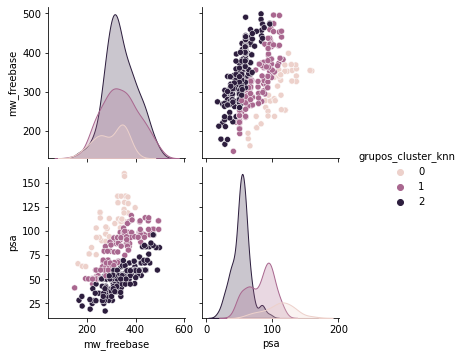

In [24]:
sns.pairplot(tab_usada[['mw_freebase', 'psa', 'grupos_cluster_knn']], hue='grupos_cluster_knn')
